In [15]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Flatten, Lambda
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.losses import binary_crossentropy, kullback_leibler_divergence
from keras import backend as K
from struct import unpack
import matplotlib.pyplot as plt
import json
import glob
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
from keras.optimizers import Adam
from io import BytesIO
import PIL
from PIL import ImageDraw
from keras.utils import get_file
from IPython.display import clear_output, Image, display, HTML

In [7]:
BASE_PATH = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
path = get_file('cat', BASE_PATH + 'cat.bin')

In [8]:
def load_icons(path, train_size=0.85):
    x = []
    with open(path, 'rb') as f:
        while True:
            img = PIL.Image.new('L', (32, 32), 'white')
            draw = ImageDraw.Draw(img)
            header = f.read(15)
            if len(header) != 15:
                break
            strokes, = unpack('H', f.read(2))
            for i in range(strokes):
                n_points, = unpack('H', f.read(2))
                fmt = str(n_points) + 'B'
                read_scaled = lambda: (p // 8 for 
                                       p in unpack(fmt, f.read(n_points)))
                points = [*zip(read_scaled(), read_scaled())]
                draw.line(points, fill=0, width=2)
            img = img_to_array(img)
            x.append(img)
    x = np.asarray(x) / 255
    return train_test_split(x, train_size=train_size)


x_train, x_test = load_icons(path)
x_train.shape, x_test.shape

((104721, 32, 32, 1), (18481, 32, 32, 1))

In [9]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    channels = 2
    x = input_img
    for i in range(4):
        channels *= 2
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)

    x = Dense(channels)(x)

    for i in range(4):
        x = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        channels //= 2
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
conv2d_14 (Conv2D)               (None, 32, 32, 4)     40                                           
____________________________________________________________________________________________________
conv2d_15 (Conv2D)               (None, 32, 32, 4)     20                                           
____________________________________________________________________________________________________
concatenate_5 (Concatenate)      (None, 32, 32, 8)     0                                            
___________________________________________________________________________________________

In [10]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 104721 samples, validate on 18481 samples
Epoch 1/100
104721/104721 [==============================] - 7s - loss: 0.4653 - val_loss: 0.4271
Epoch 2/100
104721/104721 [==============================] - 7s - loss: 0.4055 - val_loss: 0.3928
Epoch 3/100
104721/104721 [==============================] - 7s - loss: 0.3857 - val_loss: 0.3791
Epoch 4/100
104721/104721 [==============================] - 7s - loss: 0.3729 - val_loss: 0.3723
Epoch 5/100
104721/104721 [==============================] - 7s - loss: 0.3630 - val_loss: 0.3599
Epoch 6/100
104721/104721 [==============================] - 7s - loss: 0.3545 - val_loss: 0.3510
Epoch 7/100
104721/104721 [==============================] - 7s - loss: 0.3470 - val_loss: 0.3457
Epoch 8/100
104721/104721 [==============================] - 7s - loss: 0.3408 - val_loss: 0.3454
Epoch 9/100
104721/104721 [==============================] - 7s - loss: 0.3353 - val_loss: 0.3344
Epoch 10/100
104721/104721 [==============================] - 7s - 

104721/104721 [==============================] - 7s - loss: 0.2547 - val_loss: 0.2576
Epoch 84/100
104721/104721 [==============================] - 7s - loss: 0.2544 - val_loss: 0.2653
Epoch 85/100
104721/104721 [==============================] - 7s - loss: 0.2542 - val_loss: 0.2562
Epoch 86/100
104721/104721 [==============================] - 7s - loss: 0.2539 - val_loss: 0.2570
Epoch 87/100
104721/104721 [==============================] - 7s - loss: 0.2535 - val_loss: 0.2550
Epoch 88/100
104721/104721 [==============================] - 7s - loss: 0.2534 - val_loss: 0.2567
Epoch 89/100
104721/104721 [==============================] - 7s - loss: 0.2530 - val_loss: 0.2562
Epoch 90/100
104721/104721 [==============================] - 7s - loss: 0.2527 - val_loss: 0.2546
Epoch 91/100
104721/104721 [==============================] - 7s - loss: 0.2525 - val_loss: 0.2559
Epoch 92/100
104721/104721 [==============================] - 7s - loss: 0.2523 - val_loss: 0.2519
Epoch 93/100
104721/104

In [11]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

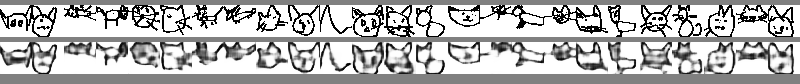

In [12]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))



In [13]:
batch_size = 250
latent_space_depth = 64

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps


In [16]:
def VariationalAutoEncoder(num_pixels):
    
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(5):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(channels)(x)
    encoder_hidden = Flatten()(x)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.0001 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)

    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return binary_crossentropy(y_true, y_pred)

    def total_loss(y_true, y_pred):
        return reconstruction_loss(y_true, y_pred) + KL_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    decoder_in = Input(shape=(latent_space_depth,))

    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    e_x = Reshape((1, 1, latent_space_depth))(z)
    for i in range(5):
        conv = Conv2D(channels, (3, 3), activation='relu', padding='same')
        upsampling = UpSampling2D((2, 2))
        d_x = conv(d_x)
        d_x = upsampling(d_x)
        e_x = conv(e_x)
        e_x = upsampling(e_x)
        channels //= 2

    final_conv = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    auto_decoded = final_conv(e_x)
    decoder_out = final_conv(d_x)
    
    decoder = Model(decoder_in, decoder_out)    
    
    auto_encoder = Model(input_img, auto_decoded)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

variational_auto_encoder, variational_decoder = VariationalAutoEncoder(x_train.shape[1])
variational_auto_encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
conv2d_43 (Conv2D)               (None, 32, 32, 4)     40                                           
____________________________________________________________________________________________________
conv2d_44 (Conv2D)               (None, 32, 32, 4)     20                                           
____________________________________________________________________________________________________
concatenate_14 (Concatenate)     (None, 32, 32, 8)     0                                            
___________________________________________________________________________________________

In [17]:
x_train_2 = x_train[:-(x_train.shape[0] % batch_size),:,: :]
x_test_2 = x_test[:-(x_test.shape[0] % batch_size),:,: :]
x_train_2.shape, x_test_2.shape

((104500, 32, 32, 1), (18250, 32, 32, 1))

In [18]:
variational_auto_encoder.fit(x_train_2, x_train_2, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_2, x_test_2))

Train on 104500 samples, validate on 18250 samples
Epoch 1/100
104500/104500 [==============================] - 7s - loss: 0.4812 - KL_loss: 0.0044 - reconstruction_loss: 0.4767 - val_loss: 0.4315 - val_KL_loss: 0.0079 - val_reconstruction_loss: 0.4236
Epoch 2/100
104500/104500 [==============================] - 6s - loss: 0.4100 - KL_loss: 0.0083 - reconstruction_loss: 0.4018 - val_loss: 0.3929 - val_KL_loss: 0.0091 - val_reconstruction_loss: 0.3838
Epoch 3/100
104500/104500 [==============================] - 6s - loss: 0.3827 - KL_loss: 0.0095 - reconstruction_loss: 0.3732 - val_loss: 0.3738 - val_KL_loss: 0.0097 - val_reconstruction_loss: 0.3641
Epoch 4/100
104500/104500 [==============================] - 6s - loss: 0.3688 - KL_loss: 0.0097 - reconstruction_loss: 0.3591 - val_loss: 0.3629 - val_KL_loss: 0.0098 - val_reconstruction_loss: 0.3531
Epoch 5/100
104500/104500 [==============================] - 6s - loss: 0.3584 - KL_loss: 0.0099 - reconstruction_loss: 0.3484 - val_loss: 0.

104500/104500 [==============================] - 6s - loss: 0.2952 - KL_loss: 0.0127 - reconstruction_loss: 0.2825 - val_loss: 0.2974 - val_KL_loss: 0.0128 - val_reconstruction_loss: 0.2845
Epoch 42/100
104500/104500 [==============================] - 6s - loss: 0.2949 - KL_loss: 0.0127 - reconstruction_loss: 0.2822 - val_loss: 0.2953 - val_KL_loss: 0.0127 - val_reconstruction_loss: 0.2826
Epoch 43/100
104500/104500 [==============================] - 6s - loss: 0.2946 - KL_loss: 0.0127 - reconstruction_loss: 0.2819 - val_loss: 0.2971 - val_KL_loss: 0.0126 - val_reconstruction_loss: 0.2845
Epoch 44/100
104500/104500 [==============================] - 6s - loss: 0.2939 - KL_loss: 0.0128 - reconstruction_loss: 0.2811 - val_loss: 0.2958 - val_KL_loss: 0.0127 - val_reconstruction_loss: 0.2831
Epoch 45/100
104500/104500 [==============================] - 6s - loss: 0.2936 - KL_loss: 0.0128 - reconstruction_loss: 0.2809 - val_loss: 0.2931 - val_KL_loss: 0.0128 - val_reconstruction_loss: 0.280

104500/104500 [==============================] - 6s - loss: 0.2811 - KL_loss: 0.0141 - reconstruction_loss: 0.2670 - val_loss: 0.2815 - val_KL_loss: 0.0140 - val_reconstruction_loss: 0.2675
Epoch 82/100
104500/104500 [==============================] - 6s - loss: 0.2807 - KL_loss: 0.0141 - reconstruction_loss: 0.2667 - val_loss: 0.2809 - val_KL_loss: 0.0140 - val_reconstruction_loss: 0.2669
Epoch 83/100
104500/104500 [==============================] - 6s - loss: 0.2804 - KL_loss: 0.0141 - reconstruction_loss: 0.2663 - val_loss: 0.2809 - val_KL_loss: 0.0140 - val_reconstruction_loss: 0.2669
Epoch 84/100
104500/104500 [==============================] - 6s - loss: 0.2801 - KL_loss: 0.0142 - reconstruction_loss: 0.2659 - val_loss: 0.2805 - val_KL_loss: 0.0140 - val_reconstruction_loss: 0.2665
Epoch 85/100
104500/104500 [==============================] - 6s - loss: 0.2798 - KL_loss: 0.0142 - reconstruction_loss: 0.2656 - val_loss: 0.2800 - val_KL_loss: 0.0142 - val_reconstruction_loss: 0.265

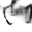

In [19]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(variational_decoder.predict(random_number).reshape(img_width, img_height))


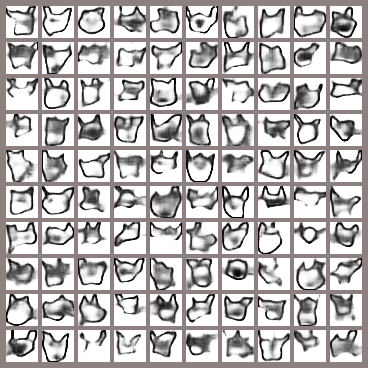

In [20]:
num_cells = 10
img_width = img_height = 32
overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))

for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
        decoded = variational_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [48]:
decoded.shape

(1, 32, 32, 1)

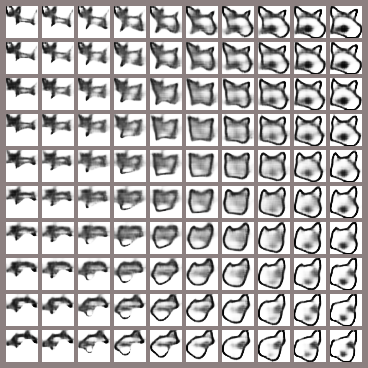

In [22]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[ - (i % 2) * (x - 4.5) / 3 + ((i + 1) % 2) * (y - 4.5) / 3
                            for i in range(latent_space_depth)]])
        decoded = variational_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview